In [1]:
# Data Analysis of Petroleum Product Consumption in India Using PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat_ws, to_date, regexp_replace, sum as _sum, avg, lit

spark = SparkSession.builder \
    .appName("Petroleum Consumption Analysis") \
    .getOrCreate()

In [2]:
file_path = "productconsumption.csv"  
df = spark.read.csv(file_path, header=True, inferSchema=True)
print("Schema:")
df.printSchema()

Schema:
root
 |-- Month: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- PRODUCTS: string (nullable = true)
 |-- Quantity (000 Metric Tonnes): double (nullable = true)
 |-- updated_date: date (nullable = true)



In [3]:

# Data Cleaning & Preparation
 
df = df.withColumnRenamed("Quantity (000 Metric Tonnes)", "Quantity")

# Creating a proper date column using Month and Year
df = df.withColumn("Date",
                   to_date(concat_ws("-", col("Year"), col("Month"), lit("01")), "yyyy-MMMM-dd"))

# Cleaning numeric column (removing commas and cast to double)
df = df.withColumn("Quantity", regexp_replace(col("Quantity"), ",", "").cast("double"))

# Dropping rows with missing values
df_clean = df.dropna(subset=["Date", "Quantity", "PRODUCTS"])

In [14]:
df.printSchema()

root
 |-- Month: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- PRODUCTS: string (nullable = true)
 |-- Quantity: double (nullable = true)
 |-- updated_date: date (nullable = true)
 |-- Date: date (nullable = false)



In [20]:
# New Date column using month and year 
df.select("Date").show()

+----------+
|      Date|
+----------+
|2023-08-01|
|2023-07-01|
|2023-06-01|
|2023-05-01|
|2023-04-01|
|2023-03-01|
|2023-02-01|
|2023-01-01|
|2022-12-01|
|2022-11-01|
|2022-10-01|
|2022-09-01|
|2022-08-01|
|2022-07-01|
|2022-06-01|
|2022-05-01|
|2022-04-01|
|2022-03-01|
|2022-02-01|
|2022-01-01|
+----------+
only showing top 20 rows


In [4]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [5]:
print(" Total rows after cleaning:", df_clean.count())

 Total rows after cleaning: 492


In [6]:
print(" Distinct products:", df_clean.select("PRODUCTS").distinct().count())



 Distinct products: 12


In [7]:
print(" Year range:", df_clean.agg(F.min("Year"), F.max("Year")).collect())

 Year range: [Row(min(Year)=2020, max(Year)=2023)]


In [8]:
#  Identify top 5 and bottom 5 products by total consumption

product_ranking = df_clean.groupBy("PRODUCTS") \
    .agg(F.sum("Quantity").alias("Total_Consumption")) \
    .orderBy(F.col("Total_Consumption").desc())

top5_products = product_ranking.limit(5)
bottom5_products = product_ranking.orderBy("Total_Consumption").limit(5)

print("Top 5 Petroleum Products:")
top5_products.show()

print("Bottom 5 Petroleum Products:")
bottom5_products.show()

Top 5 Petroleum Products:
+--------------+------------------+
|      PRODUCTS| Total_Consumption|
+--------------+------------------+
|           HSD|          272768.9|
|            MS|109249.89000000001|
|           LPG|          95899.56|
|Petroleum coke|56409.520000000004|
|        Others| 46845.31999999999|
+--------------+------------------+

Bottom 5 Petroleum Products:
+--------------------+------------------+
|            PRODUCTS| Total_Consumption|
+--------------------+------------------+
|                 LDO|2933.2499999999995|
|                 SKO|           4005.79|
|Lubricants & Greases|14025.859999999997|
|                 ATF|19393.929999999997|
|           FO & LSHS|          21576.08|
+--------------------+------------------+



In [9]:
# Year-on-Year Growth in Total Consumption

yearly_growth = df_clean.groupBy("Year") \
    .agg(F.sum("Quantity").alias("Total_Consumption")) \
    .withColumn("Prev_Year_Consumption",
                F.lag("Total_Consumption").over(Window.orderBy("Year"))) \
    .withColumn("Growth_Percentage",
                F.round(((F.col("Total_Consumption") - F.col("Prev_Year_Consumption")) /
                         F.col("Prev_Year_Consumption")) * 100, 2)) \
    .orderBy("Year")

print("Year-on-Year Growth in Total Petroleum Consumption:")
yearly_growth.show()


Year-on-Year Growth in Total Petroleum Consumption:
+----+------------------+---------------------+-----------------+
|Year| Total_Consumption|Prev_Year_Consumption|Growth_Percentage|
+----+------------------+---------------------+-----------------+
|2020|          141357.0|                 NULL|             NULL|
|2021|         199878.74|             141357.0|             41.4|
|2022|         219391.76|            199878.74|             9.76|
|2023|154420.82000000004|            219391.76|           -29.61|
+----+------------------+---------------------+-----------------+



In [10]:
#  Monthly Trend (Average Consumption per Month across all years)

monthly_avg = df_clean.groupBy("Month") \
    .agg(F.avg("Quantity").alias("Avg_Consumption")) \
    .orderBy(F.when(F.col("Month") == "January", 1)
                .when(F.col("Month") == "February", 2)
                .when(F.col("Month") == "March", 3)
                .when(F.col("Month") == "April", 4)
                .when(F.col("Month") == "May", 5)
                .when(F.col("Month") == "June", 6)
                .when(F.col("Month") == "July", 7)
                .when(F.col("Month") == "August", 8)
                .when(F.col("Month") == "September", 9)
                .when(F.col("Month") == "October", 10)
                .when(F.col("Month") == "November", 11)
                .when(F.col("Month") == "December", 12))

print("Average Monthly Consumption (All Products Combined):")
monthly_avg.show(12)

Average Monthly Consumption (All Products Combined):
+---------+------------------+
|    Month|   Avg_Consumption|
+---------+------------------+
|  January| 1497.223055555556|
| February|1467.4947222222224|
|    March|1649.0027777777773|
|    April|1309.5808333333332|
|      May|1438.1033333333335|
|     June|1453.2891666666662|
|     July|        1415.92375|
|   August|        1372.98125|
|September| 1322.249166666667|
|  October| 1496.715277777778|
| November|1532.1327777777778|
| December|1577.7977777777778|
+---------+------------------+



In [32]:
#  Most Consistent (Least Variable) Products

consistency_df = df_clean.groupBy("PRODUCTS") \
    .agg(F.stddev("Quantity").alias("Std_Deviation"),
         F.avg("Quantity").alias("Avg_Consumption")) \
    .withColumn("Consistency_Index", F.round(F.col("Std_Deviation") / F.col("Avg_Consumption"), 3)) \
    .orderBy("Consistency_Index")

print("Most Consistent Petroleum Products (Low Consumption Variability):")
consistency_df.show(10)


Most Consistent Petroleum Products (Low Consumption Variability):
+--------------------+------------------+------------------+-----------------+
|            PRODUCTS|     Std_Deviation|   Avg_Consumption|Consistency_Index|
+--------------------+------------------+------------------+-----------------+
|                 LPG|131.73369521037694|2339.0136585365854|            0.056|
|           FO & LSHS| 64.10671493594128| 526.2458536585366|            0.122|
|             Naphtha| 135.4929173218668|1098.7539024390244|            0.123|
|                 HSD| 967.6547385715637| 6652.900000000001|            0.145|
|                  MS| 412.4839830742582|2664.6314634146347|            0.155|
|Lubricants & Greases| 74.21303807201299|342.09414634146333|            0.217|
|                 LDO|15.648154687436827| 71.54268292682926|            0.219|
|      Petroleum coke| 360.1446981576955|1375.8419512195123|            0.262|
|              Others| 322.1220118852103|1142.5687804878046|     

In [33]:
#  Correlation Between Major Products (Example: HSD vs MS)

hsd = df_clean.filter(df_clean.PRODUCTS == "HSD").groupBy("Year").agg(F.sum("Quantity").alias("HSD"))
ms = df_clean.filter(df_clean.PRODUCTS == "MS").groupBy("Year").agg(F.sum("Quantity").alias("MS"))

merged = hsd.join(ms, "Year")
corr_value = merged.stat.corr("HSD", "MS")

print(f"Correlation between Diesel (HSD) and Petrol (MS) consumption: {corr_value:.3f}")

Correlation between Diesel (HSD) and Petrol (MS) consumption: 0.998


In [34]:
#  Analytical Computations


#  Yearly total consumption
yearly_total = df_clean.groupBy("Year") \
    .agg(_sum("Quantity").alias("Total_Consumption")) \
    .orderBy("Year")

#  Product-wise totals and averages
product_stats = df_clean.groupBy("PRODUCTS") \
    .agg(_sum("Quantity").alias("Total_Consumption"),
         avg("Quantity").alias("Avg_Monthly_Consumption")) \
    .orderBy(col("Total_Consumption").desc())

#  Yearly product-wise pivot
pivot_df = df_clean.groupBy("Year").pivot("PRODUCTS").agg(_sum("Quantity")).orderBy("Year")

In [35]:
import pandas as pd

In [36]:
# Converting Summaries for Visualization

yearly_pdf = yearly_total.toPandas()
product_pdf = product_stats.toPandas()
pivot_pdf = pivot_df.toPandas()

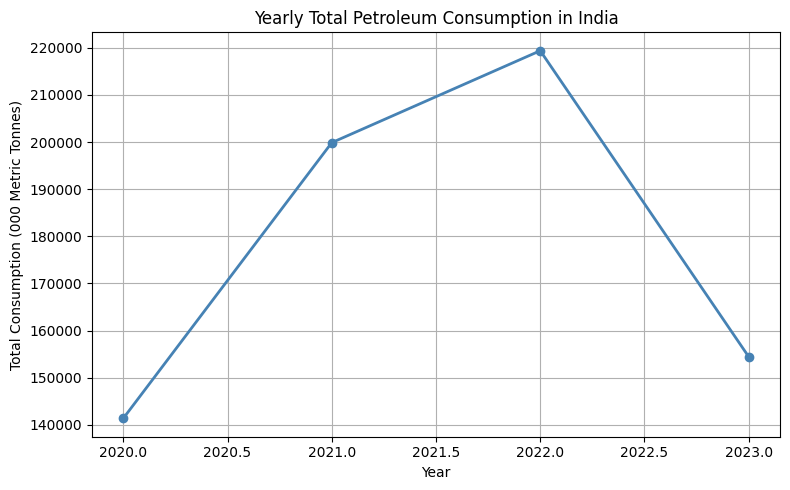

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

#  Yearly Total Petroleum Consumption (Line Chart)
plt.figure(figsize=(8,5))
plt.plot(yearly_pdf["Year"], yearly_pdf["Total_Consumption"], marker='o', linewidth=2, color='steelblue')
plt.title("Yearly Total Petroleum Consumption in India")
plt.xlabel("Year")
plt.ylabel("Total Consumption (000 Metric Tonnes)")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_7688\2270436080.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="PRODUCTS", x="Total_Consumption", data=top10, palette="crest")


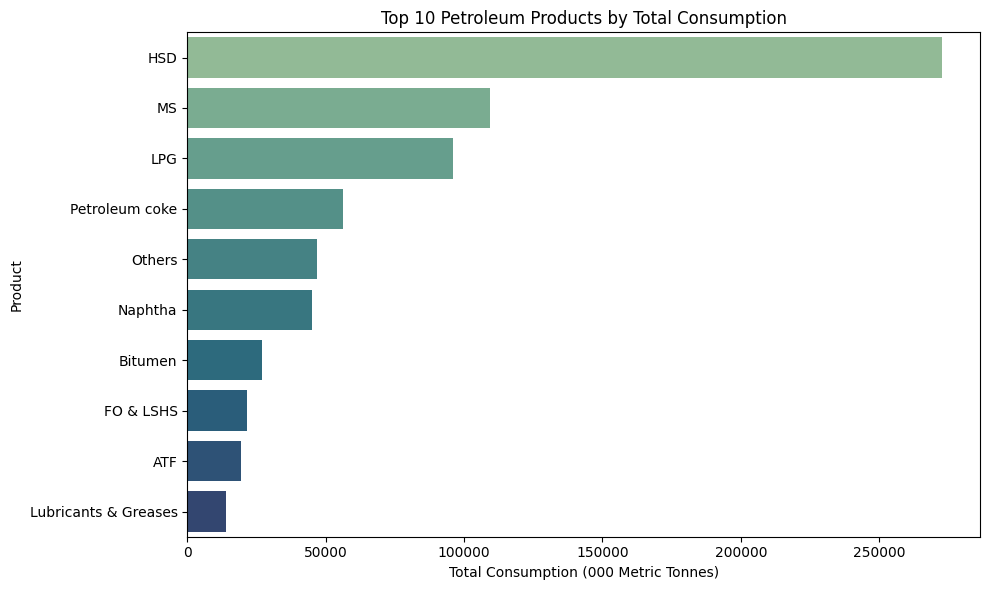

In [38]:
#  Top 10 Petroleum Products by Total Consumption (Bar Chart)
top10 = product_pdf.head(10)
plt.figure(figsize=(10,6))
sns.barplot(y="PRODUCTS", x="Total_Consumption", data=top10, palette="crest")
plt.title("Top 10 Petroleum Products by Total Consumption")
plt.xlabel("Total Consumption (000 Metric Tonnes)")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

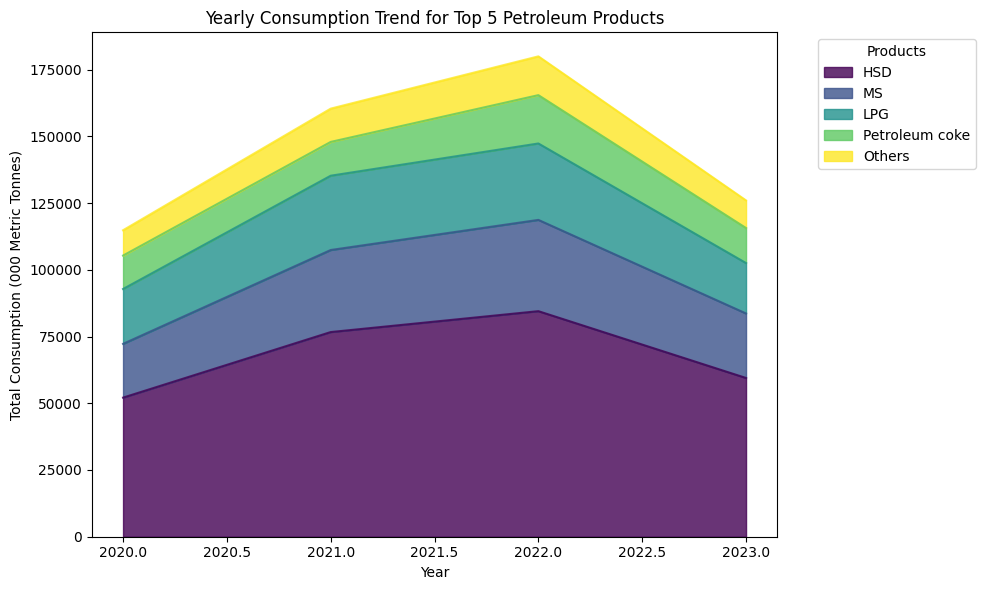

In [39]:
#  Yearly Consumption of Top 5 Products (Stacked Area Chart)
top5_products = product_pdf["PRODUCTS"].head(5).tolist()
pivot_top5 = pivot_pdf[["Year"] + top5_products].set_index("Year")

plt.figure(figsize=(10,6))
pivot_top5.plot.area(figsize=(10,6), cmap="viridis", alpha=0.8)
plt.title("Yearly Consumption Trend for Top 5 Petroleum Products")
plt.xlabel("Year")
plt.ylabel("Total Consumption (000 Metric Tonnes)")
plt.legend(title="Products", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

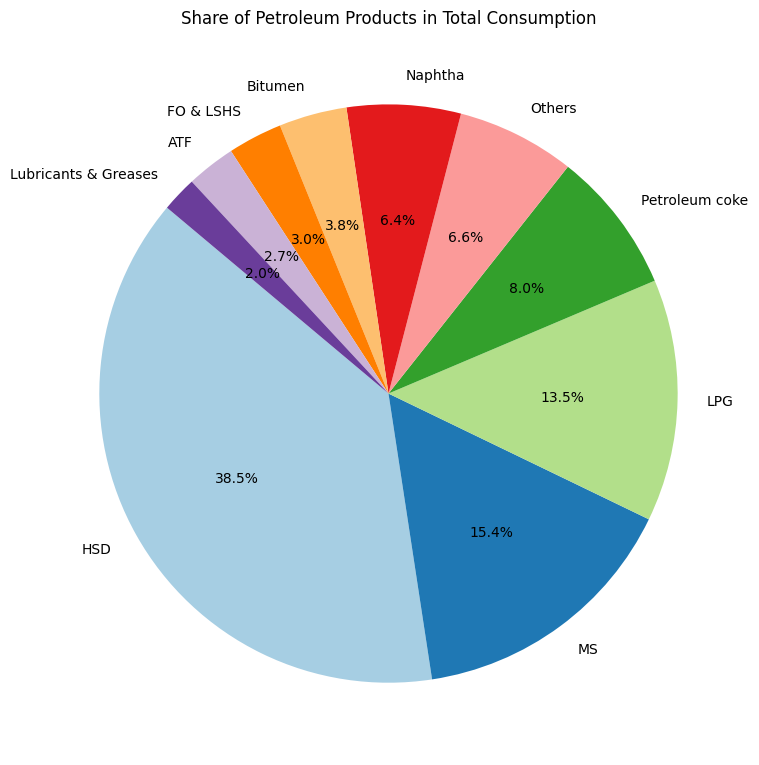

In [40]:
# Pie Chart — Product-Wise Share of Total Consumption
plt.figure(figsize=(8,8))
top10_pie = product_pdf.head(10)
plt.pie(top10_pie["Total_Consumption"],
        labels=top10_pie["PRODUCTS"],
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette("Paired", len(top10_pie)))
plt.title("Share of Petroleum Products in Total Consumption")
plt.tight_layout()
plt.show()


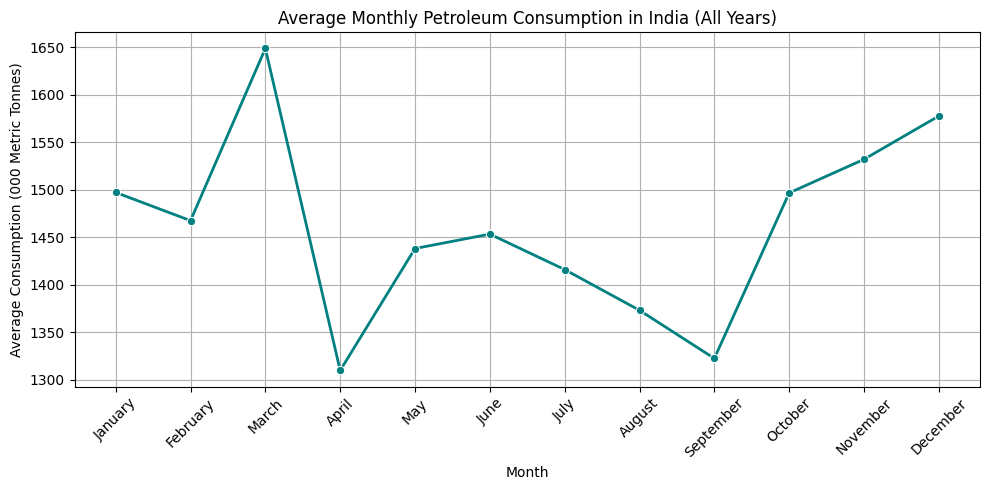

In [41]:
#  Monthly Average Petroleum Consumption (Line Chart)
monthly_avg = df_clean.groupBy("Month") \
    .agg(avg("Quantity").alias("Avg_Consumption")) \
    .orderBy(
        F.when(col("Month") == "January", 1)
         .when(col("Month") == "February", 2)
         .when(col("Month") == "March", 3)
         .when(col("Month") == "April", 4)
         .when(col("Month") == "May", 5)
         .when(col("Month") == "June", 6)
         .when(col("Month") == "July", 7)
         .when(col("Month") == "August", 8)
         .when(col("Month") == "September", 9)
         .when(col("Month") == "October", 10)
         .when(col("Month") == "November", 11)
         .when(col("Month") == "December", 12)
    )

monthly_avg_pdf = monthly_avg.toPandas()

plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_avg_pdf, x="Month", y="Avg_Consumption", marker="o", linewidth=2, color="teal")
plt.title("Average Monthly Petroleum Consumption in India (All Years)")
plt.xlabel("Month")
plt.ylabel("Average Consumption (000 Metric Tonnes)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
yearly_total.write.csv("spark_yearly_total.csv", header=True, mode="overwrite")
product_stats.write.csv("spark_product_stats.csv", header=True, mode="overwrite")
pivot_df.write.csv("spark_yearly_product_pivot.csv", header=True, mode="overwrite")

spark.stop()